# CIFAR-10 이미지 생성하기
* cifar10 이미지 50000장을 입력받아 새로운 이미지를 생성해낸다.
* cifar10 이미지 종류에는 airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck (비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭) 이 있다.

## Step 0. 중요모듈 import 하기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


## STEP 1. 데이터셋 구성하기
* 50000장의 train, 10000장의 test 데이터셋이 있다.
* 이미지의 크기는 32x32이고 3채널 RGB 이미지다.
* tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print('train_x.shape :', train_x.shape)
print('test_x.shape :', test_x.shape)

train_x.shape : (50000, 32, 32, 3)
test_x.shape : (10000, 32, 32, 3)


In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


### STEP 1-1. 정규화 하기
* 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


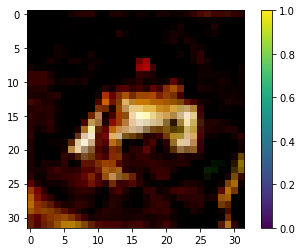

In [5]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

### STEP 1-2. 이미지 확인하기
* 어떤 이미지는 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭에 해당하지 않는 것 처럼 보인다. 
* 인덱스 0, 2, 3은 무슨 이미지인지 잘 구분이 안간다.
* gan으로 학습 후에도 알아보지 못할 이미지가 나올 확률이 꽤 있을 듯 하다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

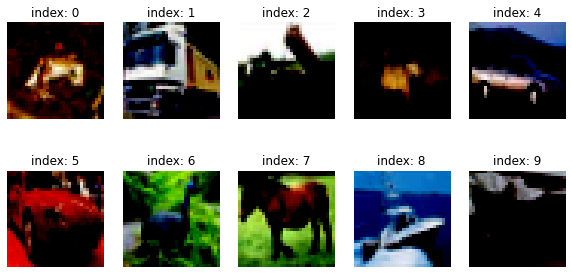

In [6]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

STEP 2. 생성자 모델 구현하기
(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.


### Step 1-3. 미지배치 구성
* tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성한다.
* train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 한다. 
* 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋다.

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다. 위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 2. 생성자 모델 구현하기
* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성했다.
* noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성.
* 노드에서 1차원 흑백 이미지는 256 -> 1으로 줄여나갔었는데, 3차원 컬러 이미지는 차원 수가 크기 때문에 1024로 시작 층을 크게 해주면 줄여나갈 때 좋은 결과가 나올 것 같아 큰 값을 넣어주었다.  그래서 1024 -> 3 으로 줄여나가게 설계했다.

In [9]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 1024)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

* 생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력

In [10]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             6553600   
_________________________________________________________________
batch_normalization (BatchNo (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         13107200  
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 512)         0

그럼 생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력해 봅시

### 2-1. 노이즈 벡터 만들기
* 아직 모델이 학습되지 않아서, 결과물도 큰 의미가 있지 않다.
* tf.random.normal함수를 사용하여 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만듦.

In [11]:
noise = tf.random.normal([1, 100])

* 텐서플로우 2.0 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성된다. 

* 지금은 학습하는 중이 아니므로 training=False를 설정해 주어야 한다. 
* Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 training=False을 주어야 올바른 결과를 얻을 수 있다.

In [12]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

* [1, 32, 32, 3] 사이즈의 이미지가 잘 생성되었다.
* 첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻을 가진다.
* matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 (32, 32) shape의 이미지를 확인.

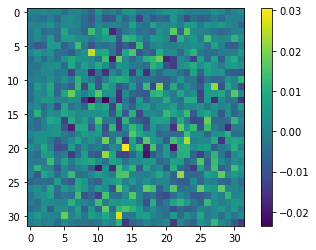

In [13]:
plt.imshow(generated_image[0, :, :, 0] )
plt.colorbar()
plt.show()

## Step 3. 판별자 모델 구현하기
* (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성.

In [14]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

* 판별자 또한 make_discriminator_model 함수로 구현.
* Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나간다.
* 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x512 = 32768, 즉 (1, 32768) 형상의 벡터로 변환한다. 

### Step 3-1. discriminator 모델 생성, summary 출력

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 256)       19456     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 512)         3277312   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 512)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)            

### Step 3-2. 가짜 이미지를 판별자에 입력

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00068606]], dtype=float32)>

## Step 4. 손실함수와 최적화 함수 구현하기
* 생성자와 판별자의 손실함수(loss)를 구현
* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현
* 생성자와 판별자를 최적화하는 optimizer를 정의

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## Step 5. 훈련과정 상세 기능 구현하기
* 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현

### Step 5-1. 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현

In [23]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### Step 5-2. 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화
* generate_and_save_image() 함수 구현

In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()
    


### Step 5-3. training_checkpoints
* training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정

In [26]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

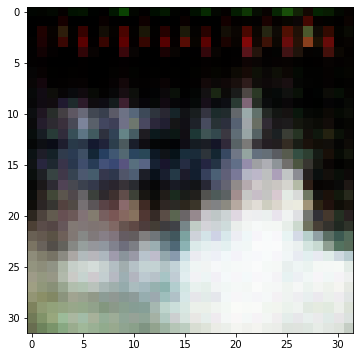

In [27]:
#checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## Step 6. 학습 과정 진행하기
* 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 보기

In [28]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [102]:
save_every_2 = 5
EPOCHS_2 = 50 
#영석님 1500번 7시간

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

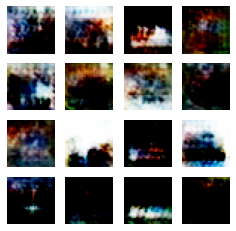

Time for training : 3556 sec


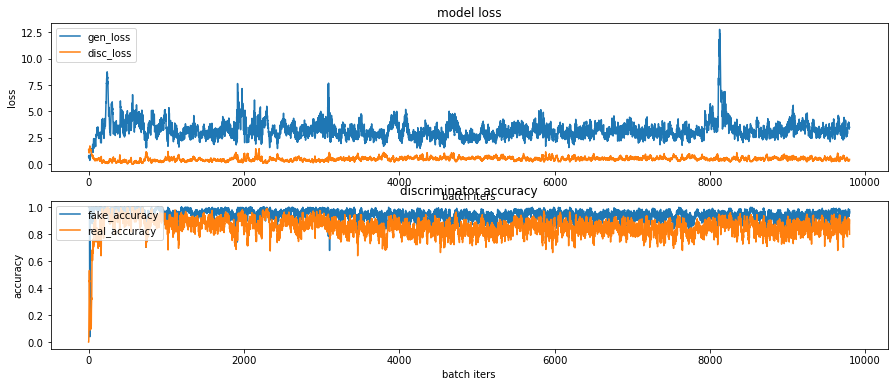

CPU times: user 58min 57s, sys: 25.5 s, total: 59min 22s
Wall time: 59min 17s


In [134]:
%%time
train(train_dataset, EPOCHS_2, save_every_2)

### Step 6-1. gif 파일로 시각화
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각화

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/epoch50.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.7)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif

![epoch50](https://user-images.githubusercontent.com/60597598/109515191-29f83380-7aea-11eb-8b03-69fc4dcbd9ba.gif)

* 에폭을 50만 했을 때 알아보기 힘든 이미지가 나왔다. 딱봐도 학습이 덜 된것 같다.
* face_accuaracy가 0.5로 향하려면 많이 부족해보였다.
* 결론 : 에폭을 500으로 높이기로 했다.

## Step 7.  GAN 훈련과정 개선하기
* 에폭을 500으로 늘려 많이 학습해보기로 했다.

In [29]:
save_every = 5
EPOCHS = 500 
#영석님 1500번 7시간

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

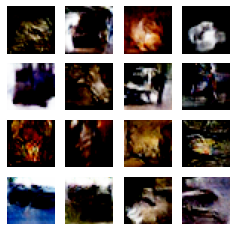

Time for training : 37220 sec


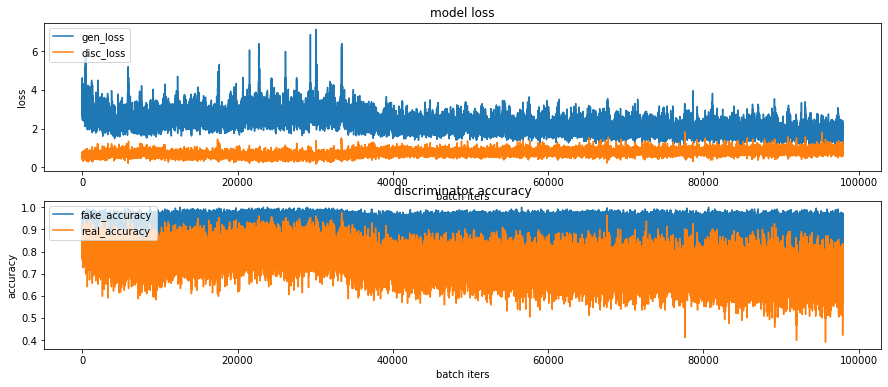

CPU times: user 10h 17min 22s, sys: 3min 51s, total: 10h 21min 13s
Wall time: 10h 20min 23s


In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

### Step 7-1.  개선사항 비교하기
* 약 10시간 정도가 걸렸고, 이미지가 전보다 좀 더 알아볼만한 것이 나온것 같다.
* fake_accuracy도 주황색에 가려졌지만 확실히 epoch 50에 비해 0.5로 향해가고 있다.

In [36]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/epoch500_2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.65)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif

ls: cannot access '/home/aiffel-dj17/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif': No such file or directory


![epoch500_2](https://user-images.githubusercontent.com/60597598/109515930-fe297d80-7aea-11eb-938c-26d5438c8213.gif)

## Step 8. 어떤 이미지 같은지 생각해보기
* 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭 중에 어떤 이미지일까? 내 생각대로 추론해보았다.
* 2번 : 불독 같은 강아지?
* 4번 : 고양이?
* 5번 :개 
* 6번 :사슴
* 7번 : 고양이?
* 9번 : 말
* 11번 : 말
* 13번 자동차?
* 14번 : 자동차 ?

# 마치며...
* 레이어를 1024 이렇게 큰 값으로 깊게 쌓아서 전반적으로 이미지가 어둡고 괴상하게 나온것 같다. 그리고 이런 1024를 주니 시간도 더 오래걸린 것 같다. 다른 팀원분들은 에폭 500 정도면 6시간 정도 걸렸다고 하는데 10시간이 걸렸으니 말이다. 모델을 돌리고 잤는데 너무 시끄러워서 중간중간 깨서 힘들었다.